<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/CDAE_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab routines

In [1]:
!pip3 install torch

In [2]:
!git clone https://github.com/annafumagalli/LISA-M-project.git

Cloning into 'LISA-M-project'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 123 (delta 3), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (123/123), 5.93 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [3]:
cd ./LISA-M-project

/content/LISA-M-project


---------------------------------

In [0]:
%matplotlib inline
import numpy as np
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from CDAE_model import *
from CDAE_training import *

import copy
import random

In [5]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training datasets

Randomly generate different type of signals within fixed parameter ranges and mix them together to create traning datasets.

- 100 mixed signals + clean/target sources signals

In [0]:
def normalise(x):
    y = (x - x.min())/(x.max() - x.min())
    return y

In [0]:
# Fixed dataset parameters

n = 100      # number of training sets 
T = 60*5     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# FFT parameters

NFFT = 25*fs   # FTT time interval
NOVL = NFFT*0.8      # overlap
window = np.blackman(NFFT) 

## Sine waves

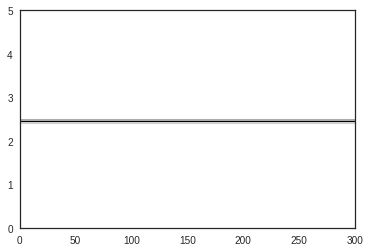

In [8]:
# Fixed:
# amplitude
a = 1.0 

# Varying:
# frequency
freq_sin = np.random.uniform(1.0, 4.0, n)

# Time Series

ts_s_train = np.zeros((n,N))
for i in range(n):
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t)
    
# Spectrograms

s_train = []
for i in range(n):
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    s_train.append(temp1)

s_train = np.array(s_train)

plt.imshow(s_train[40], aspect='auto', origin='lower', extent=[0,T,0,5])

## Sine Gaussians

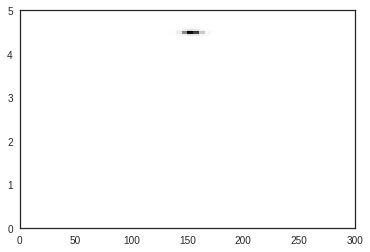

In [9]:
# Fixed:
# amplitude
a = 1.0
# envelope parameter
tau = 10.0
#frequency
freq_sg = 4.5

# Varying:
# pulse starting time
t0_sg = np.random.uniform(100.0, 200.0, n)


# Time Series

ts_sg_train = np.zeros((n,N))
for i in range(n):
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*freq_sg*(t-t0_sg[i])))
    
# Spectrograms

sg_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    sg_train.append(temp1)
sg_train = np.array(sg_train)

plt.imshow(sg_train[40], aspect='auto', origin='lower', extent=[0,T,0,5])

## Chirps

(100, 3000)

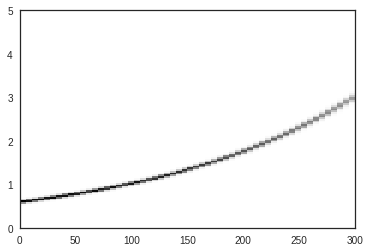

In [10]:
# Fixed:
# Chirping time
t1 = 200.0

# Varying:
# Chirp frequencies
f0 = np.random.uniform(0.5, 1.5, n)
f1 = np.random.uniform(1.5, 2.5, n)

# Time Series

ts_chirp_train = np.zeros((n,N))
for i in range(n):
    k = (f1[i]/f0[i])**(1/(t1))  
    ts_chirp_train[i,:] = a*np.sin(2.0*np.pi*f0[i]*((k**t-1)/np.log(k)))
    
# Spectrograms

chirp_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_chirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    chirp_train.append(temp1)
chirp_train = np.array(chirp_train)

plt.imshow(chirp_train[90], aspect='auto', origin='lower', extent=[0,T,0,5])

ts_chirp_train.shape

## Truncated chirps

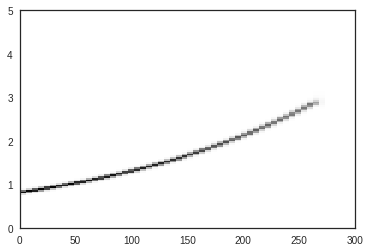

In [11]:
# Fixed:
# Chirping time
t1 = 150.0

# Varying:
# Chirp frequencies
f0 = np.random.uniform(0.5, 1.5, n)
f1 = np.random.uniform(1.5, 2.5, n)

# Time Series

ts_tchirp_train = np.zeros((n,N))
for i in range(n):
    k = (f1[i]/f0[i])**(1/(t1))  
    ts_tchirp_train[i,:2600] = a*np.sin(2.0*np.pi*f0[i]*((k**t[:2600]-1)/np.log(k)))
    ts_tchirp_train[i, 2600:] == 0
    
# Spectrograms

tchirp_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_tchirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    tchirp_train.append(temp1)
tchirp_train = np.array(tchirp_train)

plt.imshow(tchirp_train[40], aspect='auto', origin='lower', extent=[0,T,0,5])

## Frequency modulated sine waves

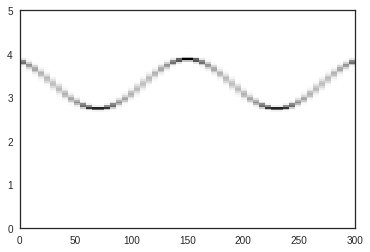

In [12]:
# Fixed:
# modulation frequency
fm = 20.0  #np.random.uniform(10.0, 10.0, n)


# Varying:
# amplitude
a = 1.0 
# carrier frequency
fc = np.random.uniform(1.0, 4.0, n)
# modulation index
B = np.random.uniform(50.0, 200.0, n)

# Time Series

ts_ms_train = np.zeros((n,N))
for i in range(n):
    ts_ms_train[i,:] = a*np.sin(2*np.pi*fc[i]*t + + B[i]*np.sin(2*np.pi*fm*t))
    
# Spectrograms

ms_train = []
for i in range(n):
    temp1, _, _ = plt.mlab.specgram(ts_ms_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    ms_train.append(temp1)

ms_train = np.array(ms_train)

plt.imshow(ms_train[0], aspect='auto', origin='lower', extent=[0,T,0,5])

## MBHB

## Mixtures

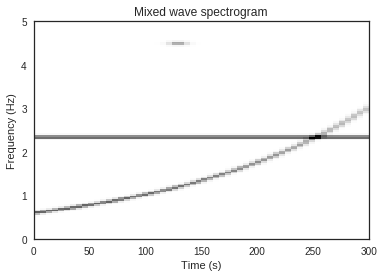

In [13]:
# MIX 1: Sine + sine gaussian + chirp

mix1_train = s_train + sg_train + chirp_train

# Normalise data arrays between [0, 1] for training

s_train = normalise(s_train)
sg_train = normalise(sg_train)
chirp_train = normalise(chirp_train)
mix1_train = normalise(mix1_train)

plt.imshow(mix1_train[90], aspect='auto', origin='lower', extent=[0,T,0,5])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed wave spectrogram')

plt.show()

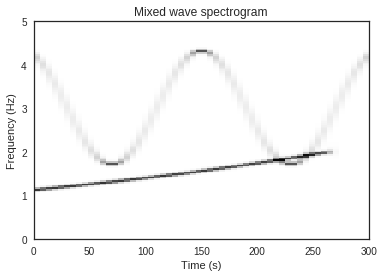

In [14]:
# MIX 2: Truncated chirp + frequency modulated sine

mix2_train = tchirp_train + ms_train

# Normalise data arrays between [0, 1] for training

ms_train = normalise(ms_train)
tchirp_train = normalise(tchirp_train)
mix2_train = normalise(mix2_train)

plt.imshow(mix2_train[30], aspect='auto', origin='lower', extent=[0,T,0,5])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed wave spectrogram')

plt.show()

In [15]:
spec_size=(mix2_train.shape[1], mix2_train.shape[2])

print(spec_size)

(126, 56)


# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [16]:
model = CDAE().to(device)

summary(model, (1, 126, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 10, 126, 56]           1,690
              Tanh-2          [-1, 10, 126, 56]               0
         MaxPool2d-3           [-1, 10, 42, 28]               0
            Conv2d-4           [-1, 20, 42, 28]           1,800
              Tanh-5           [-1, 20, 42, 28]               0
         MaxPool2d-6           [-1, 20, 14, 14]               0
            Conv2d-7           [-1, 30, 14, 14]           5,400
              Tanh-8           [-1, 30, 14, 14]               0
            Conv2d-9           [-1, 40, 14, 14]          10,800
             Tanh-10           [-1, 40, 14, 14]               0
  ConvTranspose2d-11           [-1, 30, 42, 28]           7,200
             Tanh-12           [-1, 30, 42, 28]               0
  ConvTranspose2d-13          [-1, 20, 126, 56]           3,600
             Tanh-14          [-1, 20, 

# Training

start training...
epoch 0, loss 0.009854825213551521


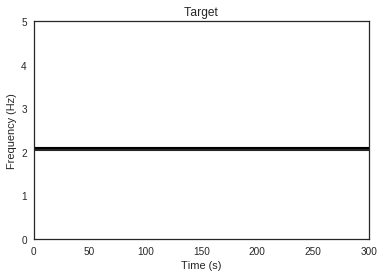

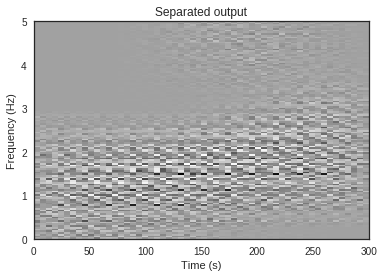

epoch 500, loss 0.00019704282749444246


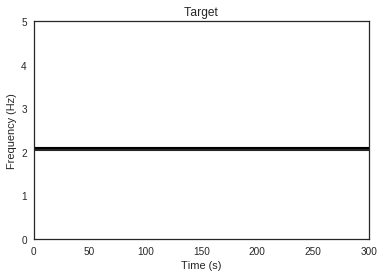

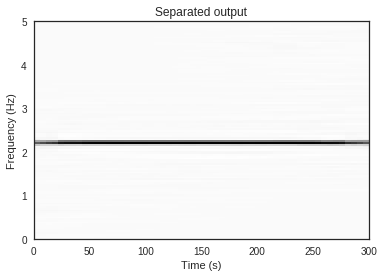

epoch 1000, loss 9.527528891339898e-05


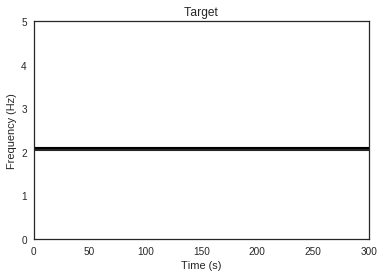

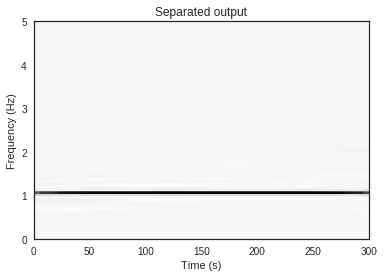

epoch 1500, loss 7.643045682925731e-05


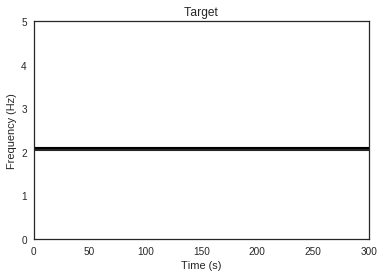

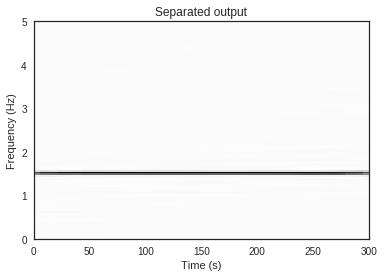

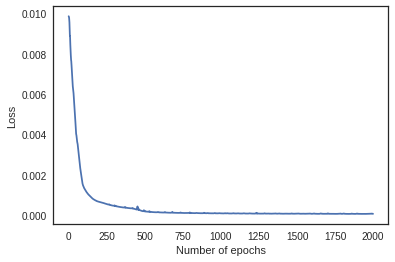

Saving trained model...
Model s_net_12-02-2019_17:23:50.pt saved.


In [17]:
# MIX 1

# Sine

model = CDAE().to(device)

trainer1 = CDAE_trainer(model=model,
                       #path='/home/annaf/LDC_project/masters_project/saved_models',
                       path='/content/LISA-M-project',
                       filename='s_net')

print('start training...')
trainer1.train(mixed_input=mix1_train,
              target=s_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=2000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.0005707554519176483


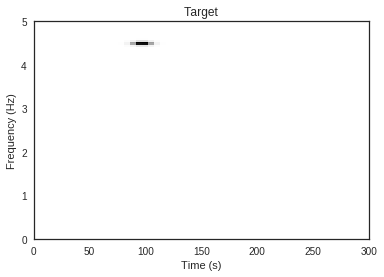

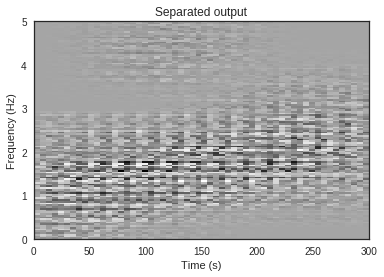

epoch 500, loss 2.225468779215589e-05


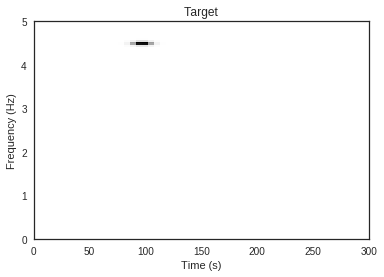

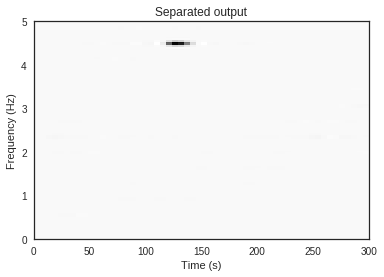

epoch 1000, loss 2.1262139853206463e-05


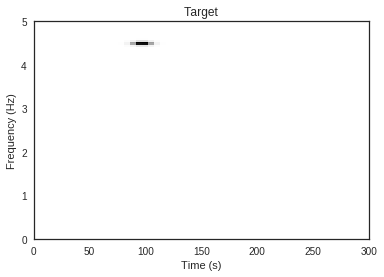

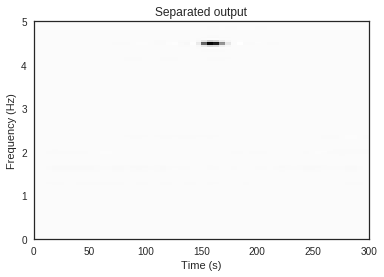

epoch 1500, loss 2.1078150894027203e-05


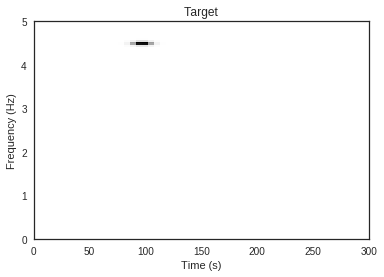

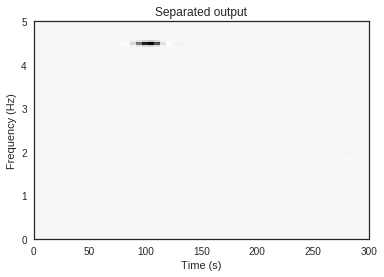

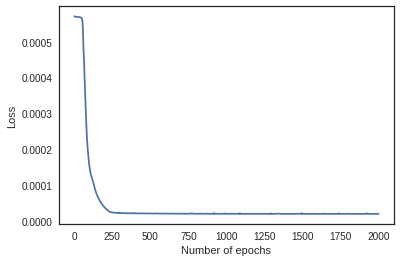

Saving trained model...
Model sg_net_12-02-2019_17:30:49.pt saved.


In [20]:
# MIX 1

# Sine gaussian

model = CDAE().to(device) #redifining the model re-randomises the weights after previous training

trainer2 = CDAE_trainer(model=model,
                       #path='/home/annaf/LDC_project/masters_project/saved_models',
                       path='/content/LISA-M-project',
                       filename='sg_net')

print('start training...')
trainer2.train(mixed_input=mix1_train,
              target=sg_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=2000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.008142716251313686


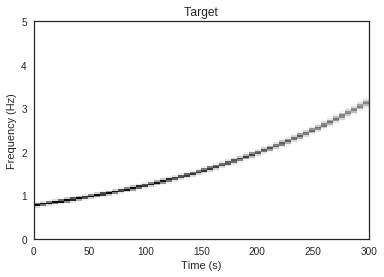

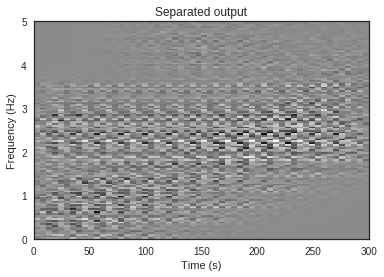

epoch 500, loss 0.0004956970806233585


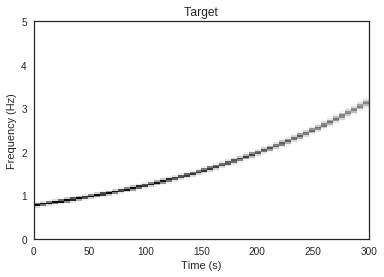

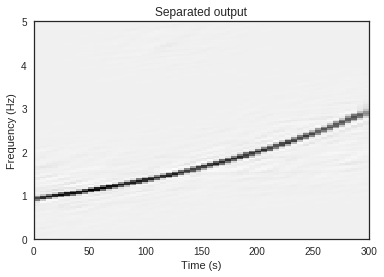

epoch 1000, loss 0.00032496952917426825


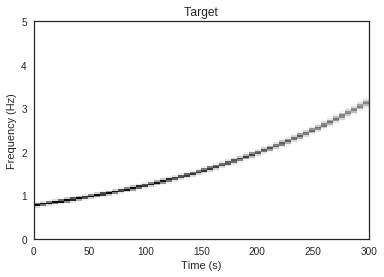

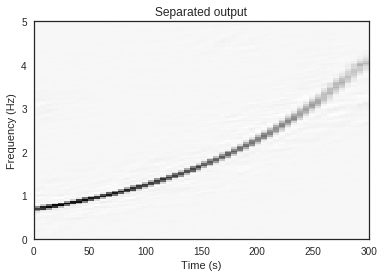

epoch 1500, loss 0.00027917171246372163


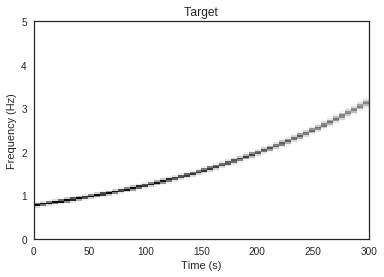

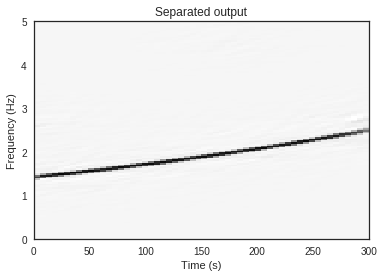

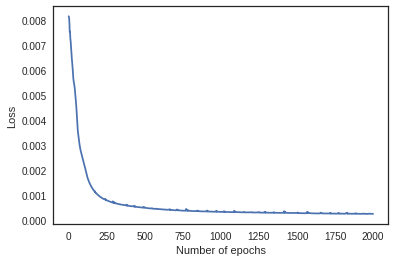

Saving trained model...
Model chirp_net_12-02-2019_17:33:25.pt saved.


In [21]:
# MIX 1

# Chirp

model = CDAE().to(device)

trainer3 = CDAE_trainer(model=model,
                       #path='/home/annaf/LDC_project/masters_project/saved_models',
                       path='/content/LISA-M-project',
                       filename='chirp_net')

print('start training...')
trainer3.train(mixed_input=mix1_train,
              target=chirp_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=2000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.006536006461828947


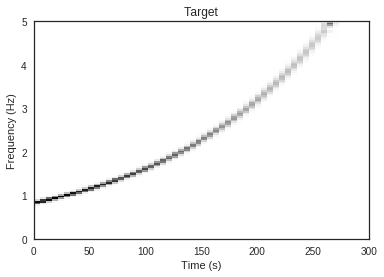

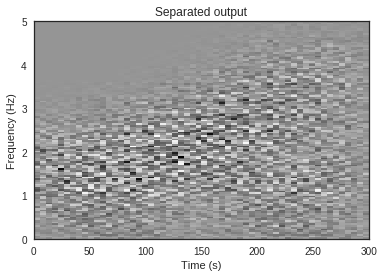

epoch 500, loss 0.0006248924182727933


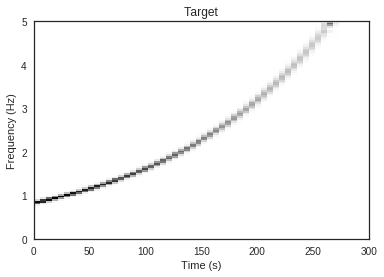

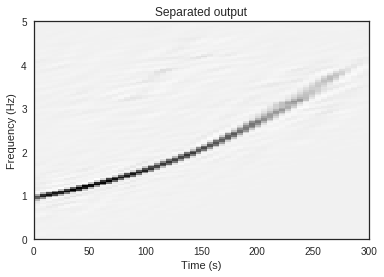

epoch 1000, loss 0.00047179986722767353


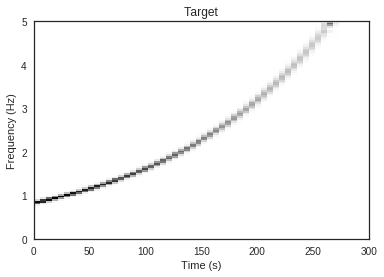

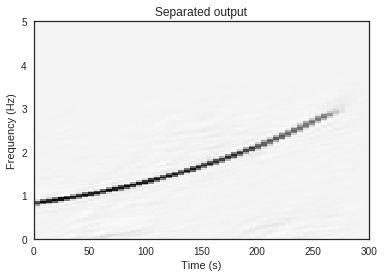

epoch 1500, loss 0.00041850455454550683


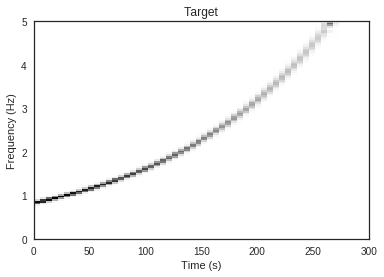

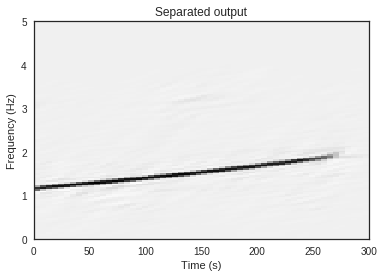

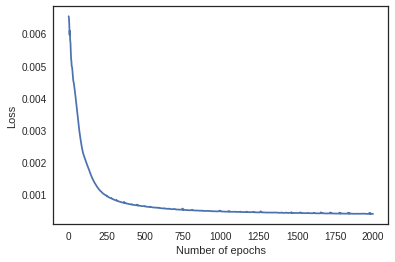

Saving trained model...
Model tchirp_net_12-02-2019_17:38:09.pt saved.


In [23]:
# MIX 2 

# Truncated chirp

model = CDAE().to(device)

trainer4 = CDAE_trainer(model=model,
                       #path='/home/annaf/LDC_project/masters_project/saved_models',
                       path='/content/LISA-M-project',
                       filename='tchirp_net')


print('start training...')
trainer4.train(mixed_input=mix2_train,
              target=tchirp_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=2000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.0021749003790318966


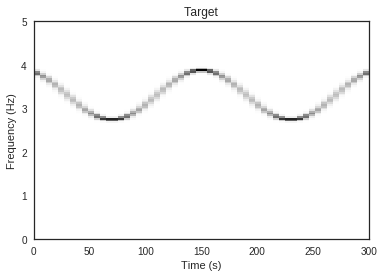

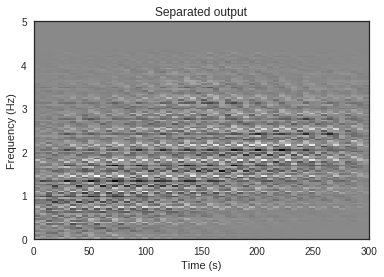

epoch 500, loss 0.0004922631196677685


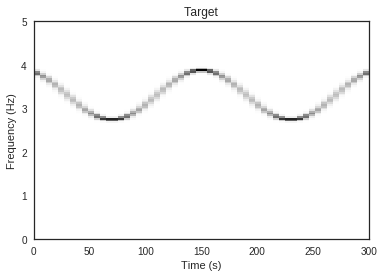

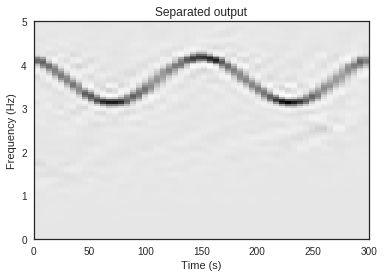

epoch 1000, loss 0.00035434638266451657


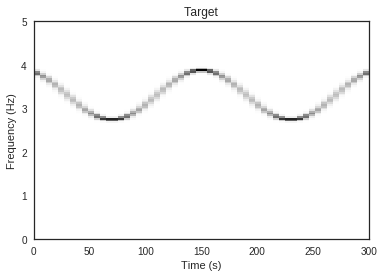

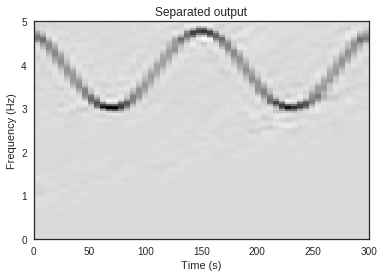

epoch 1500, loss 0.0003146755916532129


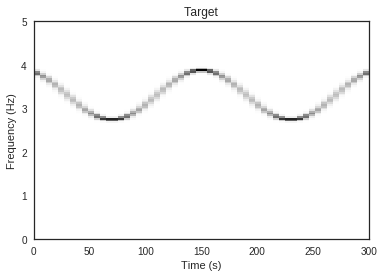

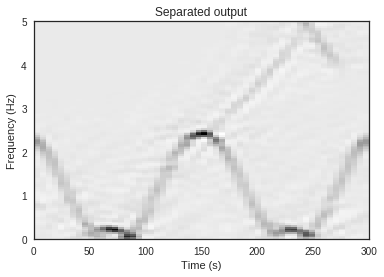

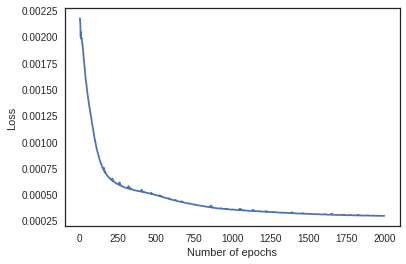

Saving trained model...
Model ms_net_12-02-2019_17:40:45.pt saved.


In [24]:
# MIX 2 

# Frequency modulated sine

model = CDAE().to(device)

trainer5 = CDAE_trainer(model=model,
                       #path='/home/annaf/LDC_project/masters_project/saved_models',
                       path='/content/LISA-M-project',
                       filename='ms_net')


print('start training...')
trainer5.train(mixed_input=mix2_train,
              target=ms_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=2000,
              H=spec_size[0],
              W=spec_size[1])